In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Matplotlib is building the font cache; this may take a moment.


In [ ]:
# Download latest version of hospital dataset
import kagglehub

path = kagglehub.dataset_download("noeyislearning/weekly-hospital-respiratory-data-and-metrics")
# Print the path for the dataset
print("Path to dataset files:", path)

/Users/chicheng/Documents/Dev/interview/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 1.09M/1.09M [00:00<00:00, 2.06MB/s]

Extracting files...


In [4]:
# Read the data
csv_path = 'data/raw_weekly_hospital_respiratory_data_2020_2024.csv'

# Read the CSV into a DataFrame
df = pd.read_csv(csv_path)

# Display the first few rows to verify
df.head()

,Week Ending Date,Geographic aggregation,Number of Inpatient Beds,Number of Adult Inpatient Beds,Number of Pediatric Inpatient beds,Number of Inpatient Beds Occupied,Number of Adult Inpatient Beds Occupied,Number of Pediatric Inpatient Beds Occupied,Number of ICU Beds,Number of Adult ICU Beds,...,Absolute Change in the Percent Hospitals Reporting Adult RSV Admissions from Prior Week,Absolute Change in the Percent Hospitals Reporting RSV Admissions from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Occupied from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent ICU Beds Occupied from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Occupied by COVID-19 Patients from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Occupied by Influenza Patients from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Occupied by RSV Patients from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent ICU Beds Occupied by COVID-19 Patients from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent ICU Beds Occupied by Influenza Patients from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent ICU Beds Occupied by RSV Patients from Prior Week
0,2023-08-12,WA,10650.0,9282.0,482.0,9040.0,8117.0,339.0,1623.0,1059.0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0
1,2023-08-12,WI,10752.0,9824.0,425.0,7574.0,7027.0,286.0,1566.0,1232.0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0
2,2023-08-12,WV,4813.0,4556.0,256.0,3701.0,3562.0,139.0,639.0,595.0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0
3,2023-08-12,WY,1318.0,1142.0,25.0,559.0,534.0,6.0,114.0,109.0,...,0.0,0.0,0.03,0.03,0.03,0.03,0.0,0.03,0.03,0.0
4,2023-08-19,AK,1354.0,1192.0,77.0,1054.0,939.0,43.0,184.0,126.0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0


In [5]:
# Necessary data check before EDA, Data Inspection and Preprocessing
# Display the number of rows and columns
print(f"Number of Rows: {df.shape[0]}")
print(f"Number of Columns: {df.shape[1]}")

Number of Rows: 12768
Number of Columns: 157


In [ ]:
# List all column names
print(df.columns.tolist())

['Week Ending Date', 'Geographic aggregation', 'Number of Inpatient Beds', 'Number of Adult Inpatient Beds', 'Number of Pediatric Inpatient beds', 'Number of Inpatient Beds Occupied', 'Number of Adult Inpatient Beds Occupied', 'Number of Pediatric Inpatient Beds Occupied', 'Number of ICU Beds', 'Number of Adult ICU Beds', 'Number of Pediatric ICU Beds', 'Number of ICU Beds Occupied', 'Number of Adult ICU Beds Occupied', 'Number of Pediatric ICU Beds Occupied', 'Number of Adult Patients Hospitalized with COVID-19', 'Number of Pediatric Patients Hospitalized with COVID-19', 'Total Patients Hospitalized with COVID-19', 'Number of Adult Patients Hospitalized with Influenza', 'Number of Pedatric Patients Hospitalized with Influenza', 'Total Patients Hospitalized with Influenza', 'Number of Adult Patients Hospitalized with RSV', 'Number of Pediatric Patients Hospitalized with RSV', 'Total Patients Hospitalized with RSV', 'Number of Adult ICU Patients Hospitalized with COVID-19', 'Number of P

In [14]:
# Enumerate columns starting from 1
for idx, column in enumerate(df.columns, 1):
    print(f"{idx}: {column}")

1: Week Ending Date
2: Geographic aggregation
3: Number of Inpatient Beds
4: Number of Adult Inpatient Beds
5: Number of Pediatric Inpatient beds
6: Number of Inpatient Beds Occupied
7: Number of Adult Inpatient Beds Occupied
8: Number of Pediatric Inpatient Beds Occupied
9: Number of ICU Beds
10: Number of Adult ICU Beds
11: Number of Pediatric ICU Beds
12: Number of ICU Beds Occupied
13: Number of Adult ICU Beds Occupied
14: Number of Pediatric ICU Beds Occupied
15: Number of Adult Patients Hospitalized with COVID-19
16: Number of Pediatric Patients Hospitalized with COVID-19
17: Total Patients Hospitalized with COVID-19
18: Number of Adult Patients Hospitalized with Influenza
19: Number of Pedatric Patients Hospitalized with Influenza
20: Total Patients Hospitalized with Influenza
21: Number of Adult Patients Hospitalized with RSV
22: Number of Pediatric Patients Hospitalized with RSV
23: Total Patients Hospitalized with RSV
24: Number of Adult ICU Patients Hospitalized with COVID-1

In [7]:
# Display data types of each column
print(df.dtypes)

Week Ending Date                                                                                                             object
Geographic aggregation                                                                                                       object
Number of Inpatient Beds                                                                                                    float64
Number of Adult Inpatient Beds                                                                                              float64
Number of Pediatric Inpatient beds                                                                                          float64
                                                                                                                             ...   
Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Occupied by Influenza Patients from Prior Week    float64
Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Oc

In [10]:
# Example: Convert 'Date' column to datetime
df['Week Ending Date'] = pd.to_datetime(df['Week Ending Date'], errors='coerce')

# Example: Convert 'Category' column to category type
df['Geographic aggregation'] = df['Geographic aggregation'].astype('category')

# Print data types
print(df.dtypes)

Week Ending Date                                                                                                            datetime64[ns]
Geographic aggregation                                                                                                            category
Number of Inpatient Beds                                                                                                           float64
Number of Adult Inpatient Beds                                                                                                     float64
Number of Pediatric Inpatient beds                                                                                                 float64
                                                                                                                                 ...      
Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Occupied by Influenza Patients from Prior Week           float64
Absolute Change in the Perc

In [11]:
df.head(10)

,Week Ending Date,Geographic aggregation,Number of Inpatient Beds,Number of Adult Inpatient Beds,Number of Pediatric Inpatient beds,Number of Inpatient Beds Occupied,Number of Adult Inpatient Beds Occupied,Number of Pediatric Inpatient Beds Occupied,Number of ICU Beds,Number of Adult ICU Beds,...,Absolute Change in the Percent Hospitals Reporting Adult RSV Admissions from Prior Week,Absolute Change in the Percent Hospitals Reporting RSV Admissions from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Occupied from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent ICU Beds Occupied from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Occupied by COVID-19 Patients from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Occupied by Influenza Patients from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent Inpatient Beds Occupied by RSV Patients from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent ICU Beds Occupied by COVID-19 Patients from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent ICU Beds Occupied by Influenza Patients from Prior Week,Absolute Change in the Percent Hospitals Reporting Percent ICU Beds Occupied by RSV Patients from Prior Week
0,2023-08-12,WA,10650.0,9282.0,482.0,9040.0,8117.0,339.0,1623.0,1059.0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0
1,2023-08-12,WI,10752.0,9824.0,425.0,7574.0,7027.0,286.0,1566.0,1232.0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0
2,2023-08-12,WV,4813.0,4556.0,256.0,3701.0,3562.0,139.0,639.0,595.0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0
3,2023-08-12,WY,1318.0,1142.0,25.0,559.0,534.0,6.0,114.0,109.0,...,0.0,0.0,0.03,0.03,0.03,0.03,0.0,0.03,0.03,0.0
4,2023-08-19,AK,1354.0,1192.0,77.0,1054.0,939.0,43.0,184.0,126.0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0
5,2023-08-19,AL,12977.0,12059.0,510.0,9760.0,9128.0,286.0,1668.0,1548.0,...,0.0,0.0,0.00,0.00,0.00,0.02,0.0,0.00,0.02,0.0
6,2023-08-19,AR,7453.0,6803.0,427.0,5201.0,4724.0,295.0,1143.0,865.0,...,0.0,0.0,0.00,0.00,0.00,0.02,0.0,0.00,0.02,0.0
7,2023-08-19,AS,150.0,122.0,28.0,63.0,50.0,7.0,7.0,7.0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0
8,2023-08-19,AZ,13553.0,11871.0,873.0,10426.0,9320.0,596.0,2026.0,1524.0,...,0.0,0.0,0.00,0.00,0.00,0.02,0.0,0.00,0.02,0.0
9,2023-08-19,CA,60469.0,54697.0,4188.0,46531.0,42826.0,2619.0,9795.0,6490.0,...,0.0,0.0,0.00,0.00,0.00,0.02,0.0,0.00,0.02,0.0


In [16]:
# Search for columns containing 'Total ICU Patients Hospitalized'
matching_columns = [col for col in df.columns if 'Total ICU Patients Hospitalized' in col]
print("Matching Columns:", matching_columns)

Matching Columns: ['Total ICU Patients Hospitalized with COVID-19 ', 'Total ICU Patients Hospitalized with Influenza', 'Total ICU Patients Hospitalized with RSV']


In [17]:
# Subset the data
desired_columns = [
    'Week Ending Date',
    'Geographic aggregation',
    'Number of Inpatient Beds',
    'Number of Inpatient Beds Occupied',
    'Number of ICU Beds',
    'Number of ICU Beds Occupied',
    'Total Patients Hospitalized with COVID-19',
    'Total Patients Hospitalized with Influenza',
    'Total Patients Hospitalized with RSV',
    'Total ICU Patients Hospitalized with COVID-19 ',
    'Total ICU Patients Hospitalized with Influenza',
    'Total ICU Patients Hospitalized with RSV'
]

# Subset the DataFrame to keep only the desired columns
df_subset = df[desired_columns]

# Display the first few rows of the subset DataFrame
df_subset.head()

,Week Ending Date,Geographic aggregation,Number of Inpatient Beds,Number of Inpatient Beds Occupied,Number of ICU Beds,Number of ICU Beds Occupied,Total Patients Hospitalized with COVID-19,Total Patients Hospitalized with Influenza,Total Patients Hospitalized with RSV,Total ICU Patients Hospitalized with COVID-19,Total ICU Patients Hospitalized with Influenza,Total ICU Patients Hospitalized with RSV
0,2023-08-12,WA,10650.0,9040.0,1623.0,1309.0,226.0,17.0,NaN,25.0,0.0,NaN
1,2023-08-12,WI,10752.0,7574.0,1566.0,1014.0,86.0,2.0,NaN,12.0,0.0,NaN
2,2023-08-12,WV,4813.0,3701.0,639.0,468.0,47.0,1.0,NaN,9.0,0.0,NaN
3,2023-08-12,WY,1318.0,559.0,114.0,40.0,4.0,1.0,NaN,0.0,0.0,NaN
4,2023-08-19,AK,1354.0,1054.0,184.0,139.0,12.0,0.0,NaN,1.0,0.0,NaN


In [20]:
# Remove leading and trailing spaces from all column names
df_subset.columns = df_subset.columns.str.strip()

for idx, column in enumerate(df_subset.columns, 1):
    print(f"{idx}: {column}")

1: Week Ending Date
2: Geographic aggregation
3: Number of Inpatient Beds
4: Number of Inpatient Beds Occupied
5: Number of ICU Beds
6: Number of ICU Beds Occupied
7: Total Patients Hospitalized with COVID-19
8: Total Patients Hospitalized with Influenza
9: Total Patients Hospitalized with RSV
10: Total ICU Patients Hospitalized with COVID-19
11: Total ICU Patients Hospitalized with Influenza
12: Total ICU Patients Hospitalized with RSV


In [21]:
# Count of missing values in each column
missing_values = df_subset.isnull().sum()
print(missing_values)

Week Ending Date                                      0
Geographic aggregation                                0
Number of Inpatient Beds                            247
Number of Inpatient Beds Occupied                   247
Number of ICU Beds                                  247
Number of ICU Beds Occupied                         247
Total Patients Hospitalized with COVID-19           260
Total Patients Hospitalized with Influenza          756
Total Patients Hospitalized with RSV              10656
Total ICU Patients Hospitalized with COVID-19       271
Total ICU Patients Hospitalized with Influenza      748
Total ICU Patients Hospitalized with RSV          10656
dtype: int64


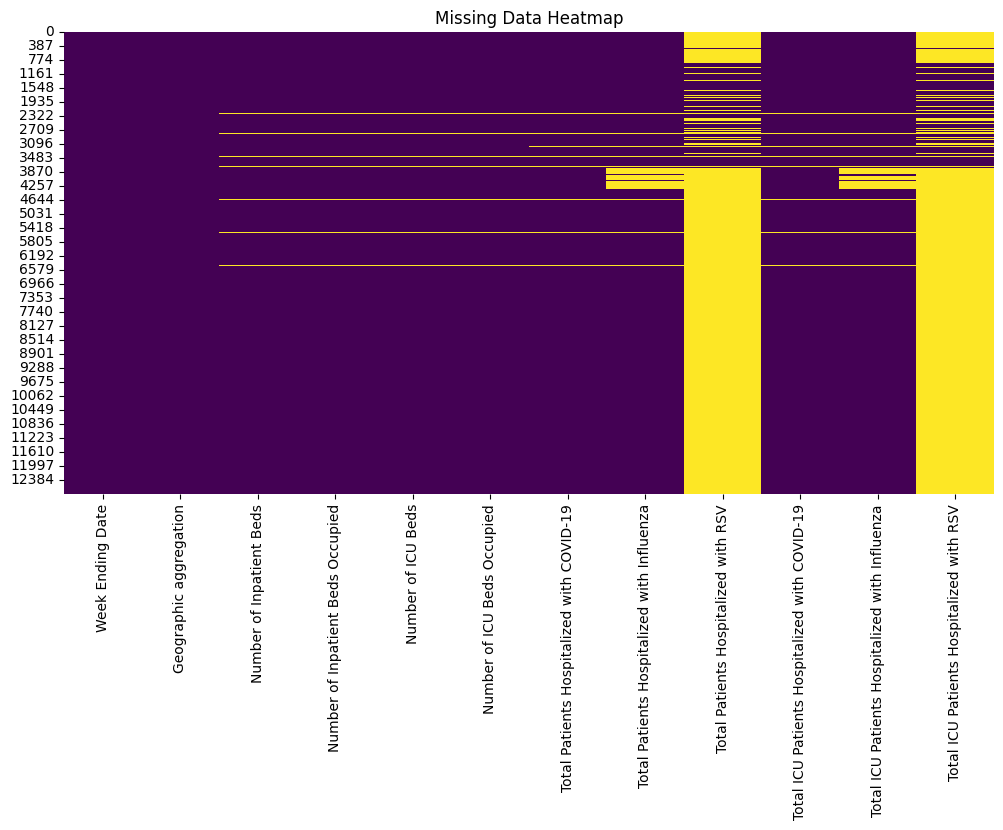

In [22]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_subset.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [ ]:
# Identify the most effecient way to impute the missing value
